# GIN Index O(N^2) Lookup

The code below demonstrates `O(N^2)` behavior for GIN index lookups using the `&& ARRAY[...]` operator where `N` is the number of elements in the array.

From my (naive) understanding of how GIN indexes work, I'd assume `O(N)` performance instead.

In [1]:
# Install dependencies
!pip3 install psycopg2-binary
!pip3 install pandas
!pip3 install matplotlib
!pip3 install numpy

In [2]:
# Import modules and setup matplotlib inlining and pandas row display options
%matplotlib inline
import psycopg2
import pandas as pd
import re
import numpy as np
from matplotlib import pyplot as plt
pd.set_option('display.max_rows', 20)

In [3]:
# Connect to our database: you may change this DSN if you're not using the supplied docker-compose file.
# We also set autocommit to True so we can run VACUUUM (which is non-transactional) below.
pg_dsn = 'postgres://postgres@localhost:9999/postgres'
conn = psycopg2.connect(pg_dsn)
conn.autocommit = True
cur = conn.cursor()

In [4]:
# Create a table with lots of rows and array elements. You can see the data in the table below.
rows = 100000
keys_per_row = 3

cur.execute("""
DROP SCHEMA IF EXISTS gin CASCADE;
CREATE SCHEMA gin;
SET search_path = gin;

CREATE TABLE example AS
SELECT 
	a AS id,
	array_agg((a-1)*%s+b) AS keys
FROM
	generate_series(1, %s) a,
	generate_series(1, %s) b
GROUP BY 1;
CREATE INDEX ON example USING GIN (keys);
""", (keys_per_row, rows, keys_per_row))
cur.execute('VACUUM ANALYZE example')

pd.read_sql_query('SELECT * from example ORDER BY id ASC', con=conn)

,id,keys
0,1,"[1, 2, 3]"
1,2,"[4, 5, 6]"
2,3,"[7, 8, 9]"
3,4,"[10, 11, 12]"
4,5,"[13, 14, 15]"
5,6,"[16, 17, 18]"
6,7,"[19, 20, 21]"
7,8,"[22, 23, 24]"
8,9,"[25, 26, 27]"
9,10,"[28, 29, 30]"


In [5]:
# The two queries we'll benchmark. query_1 is the main query we are interested in. query_2 produces the same result
# and is included for comparison.
query_1 = "EXPLAIN ANALYZE SELECT * FROM example WHERE keys && %s"
query_2 = "EXPLAIN ANALYZE SELECT DISTINCT ON (example.id) * FROM unnest(%s) key JOIN example ON keys && ARRAY[key]"

In [6]:
# Force the query planner to use our gin index, even if it would prefer a seqscan and show 
# the query plans for the queries we're testing elow. 
cur.execute("SET enable_seqscan=false")

# Show the query plans for our two queries
for q in [query_1, query_2]:
    cur.execute(q, ([1,2,3],))
    print(q+'\n'+'\n'.join([x[0] for x in cur.fetchall()])+'\n\n')

EXPLAIN ANALYZE SELECT * FROM example WHERE keys && %s
Bitmap Heap Scan on example  (cost=51.57..924.35 rows=1493 width=37) (actual time=0.030..0.035 rows=1 loops=1)
  Recheck Cond: (keys && '{1,2,3}'::integer[])
  Heap Blocks: exact=1
  ->  Bitmap Index Scan on example_keys_idx  (cost=0.00..51.19 rows=1493 width=0) (actual time=0.018..0.018 rows=1 loops=1)
        Index Cond: (keys && '{1,2,3}'::integer[])
Planning time: 0.098 ms
Execution time: 0.070 ms


EXPLAIN ANALYZE SELECT DISTINCT ON (example.id) * FROM unnest(%s) key JOIN example ON keys && ARRAY[key]
Unique  (cost=18850.84..19350.84 rows=100000 width=45) (actual time=0.220..0.252 rows=1 loops=1)
  ->  Sort  (cost=18850.84..19100.84 rows=100000 width=45) (actual time=0.210..0.224 rows=3 loops=1)
        Sort Key: example.id
        Sort Method: quicksort  Memory: 25kB
        ->  Nested Loop  (cost=18.99..7469.52 rows=100000 width=45) (actual time=0.060..0.178 rows=3 loops=1)
              ->  Function Scan on unnest key  (cos

In [7]:
# Run our benchmark, basically just running the query from above with an increasing amount of elements in the
# array we're performing an overlap operation with.
step = 100
steps = 200
results = []

def gin_query(sql, args):
    cur.execute(sql, args)
    plan = '\n'.join([x[0] for x in cur.fetchall()])
    
    # make sure all our queries used our GIN index
    if plan.find('Index Scan') < 0:
        raise Exception("unexpected query plan")

    time = float(re.search('Execution time: ([0-9.]+)', plan)[1])
    return time


for p in range(steps):
    keys = [k+1 for k in range(step * (p+1))]
    time_1 = gin_query(query_1, (keys,))
    time_2 = gin_query(query_2, (keys,))

    result = (len(keys), time_1, time_2)
    results.append(result)

    df = pd.DataFrame(results, columns=["keys", "time_1", "time_2"])
df

,keys,time_1,time_2
0,100,0.744,7.430
1,200,1.612,14.534
2,300,2.504,22.614
3,400,3.395,24.271
4,500,4.445,29.235
5,600,5.934,31.373
6,700,7.771,41.254
7,800,9.795,38.136
8,900,9.408,37.983
9,1000,11.311,43.034


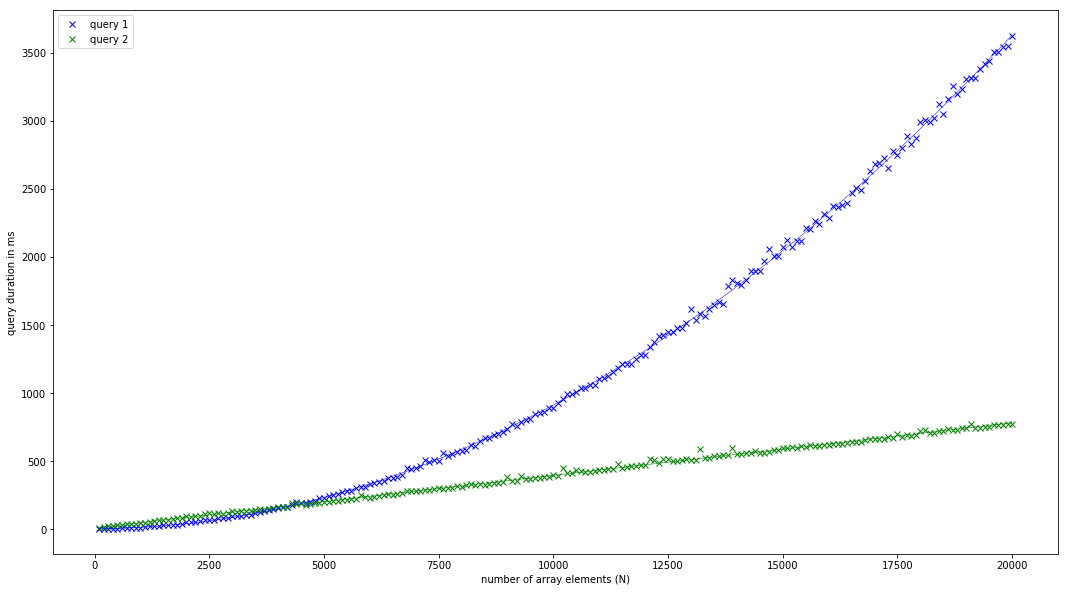

In [8]:
# fit a quadratic curve to our first query
coef_1 = np.polyfit(df['keys'], df['time_1'], 2)
p_1 = np.poly1d(coef_1)
# fit a straight line to our second query 
coef_2 = np.polyfit(df['keys'], df['time_2'], 1)
p_2 = np.poly1d(coef_2)


fig, ax = plt.subplots()
fig.set_size_inches((18, 10))
ax.plot(df['keys'], df['time_1'], "bx", markersize=6, label='query 1')
ax.plot(df['keys'], df['time_2'], "gx", markersize=6, label='query 2')
ax.plot(df['keys'], p_1(df['keys']), "b-", linewidth=0.5)
ax.plot(df['keys'], p_2(df['keys']), "g-", linewidth=0.5)
ax.set_xlabel('number of array elements (N)')
ax.set_ylabel('query duration in ms')
ax.legend()

ax